# importing libraries

In [102]:
import os
import cv2 #image processing library used for preprocessing part of the project
import matplotlib.pyplot as plt #ploting data and images
from pathlib import Path #accessing directories and paths in computer for reading/loading images/data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Loading images

In [103]:
data_dir = Path("samples/")
images = list(data_dir.glob("*.png"))

# CREATING LABELLED DATA

In [104]:
from preprocess import RemoveLineAndSegment #removing horizontal lines and segmenting every image; inputs:()
#defining two empty list for segmentation x[i]:i-th segment; y[i]:i-th segment's character; z[i]: i-th preprocessed image

In [105]:

x=[]
y=[]
z=[]
RemoveLineAndSegment(images,x,y,z)
#converting to numpy array
x=np.array(x)
y=np.array(y)

#### TO see which characters are present and their corresponding frequencies , to ensure that our data is not biase
##### the number of images for each category should be approximately uniform (i.e.,the same number of examples per category).


In [106]:
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[['2' '265']
 ['3' '266']
 ['4' '284']
 ['5' '281']
 ['6' '259']
 ['7' '258']
 ['8' '264']
 ['b' '240']
 ['c' '262']
 ['d' '259']
 ['e' '235']
 ['f' '271']
 ['g' '271']
 ['m' '275']
 ['n' '526']
 ['p' '253']
 ['w' '235']
 ['x' '264']
 ['y' '232']]


# Reshaping data for the sake of machine learning algorithms


In [107]:
knn_data=np.reshape(x,(5200, 54*30)) #one row of data
print(x.shape)
print(knn_data.shape)

(5200, 54, 30)
(5200, 1620)


##### converting labels represented as strings to integers where there is one unique integer per class label

In [108]:
from sklearn.preprocessing import LabelEncoder

In [109]:
le = LabelEncoder()
labels = le.fit_transform(y) 
# print(labels.size)
# print(labels[1])
# plt.imshow(x[0])

### partition the data into training and testing splits using 75% of the data for training and the remaining 25% for testing


In [110]:
from sklearn.model_selection import train_test_split

In [111]:
(trainX, testX, trainY, testY) = train_test_split(knn_data, labels, test_size=0.25, random_state=42)

### classification using the K-NN
1. The __classification_report__ function is another utility function that is used to help us evaluate the performance of our classifier and print a nicely formatted table of results to our console.

2. KNeighborsClassifier(n_neighbors=args["neighbors"], 48 n_jobs=args["jobs"])
    1. --neighbors: Optional, the number of neighbors k to apply when using the k-NN algorithm.

    2. --jobs: Optional, the number of concurrent jobs to run when computing the distance between an input data point and the training set. A value of -1 will use all available cores on the processor.

In [112]:
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

In [113]:
# train and evaluate a k-NN classifier on the raw pixel intensities
print("[INFO] evaluating k-NN classifier...")
model = KNeighborsClassifier(n_neighbors=19)
model.fit(trainX, trainY)
print(classification_report(testY, model.predict(testX),
target_names=le.classes_))

[INFO] evaluating k-NN classifier...
              precision    recall  f1-score   support

           2       1.00      0.90      0.95        68
           3       0.83      0.92      0.87        64
           4       0.93      0.93      0.93        71
           5       0.81      0.90      0.85        62
           6       0.95      0.67      0.78        78
           7       0.95      0.93      0.94        57
           8       1.00      0.78      0.88        74
           b       0.84      0.58      0.69        65
           c       0.82      0.81      0.82        69
           d       0.85      0.83      0.84        69
           e       1.00      0.82      0.90        57
           f       0.87      0.85      0.86        71
           g       0.96      0.93      0.94        69
           m       0.57      0.64      0.60        64
           n       0.58      0.93      0.71       122
           p       0.98      0.72      0.83        68
           w       0.95      0.90      0.93 

# Analysis on Captcha images (KNN)

In [114]:
from preprocess import Segmentation

In [162]:
def KNN_captcha(img, imgPath):
    parts=[]
    lbls=[]
    Segmentation(img,imgPath , parts, lbls)
    parts=np.reshape(parts,(5, 54*30))
    predictions = model.predict(parts)
    for i in range(5):
        if np.where(le.classes_ ==lbls[i])[0] != predictions[i]:
            return 0
    
    return 1

In [163]:
t=0
t = KNN_captcha(z[2], str(images[2]))
for i in range(len(z)):
    t+=KNN_captcha(z[i],str(images[i]))
print(t/len(z))

0.5826923076923077


# shallow net architecture

In [164]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from model import ShallowNet
from keras.optimizers import SGD

1. width: The width of the input images that will be used to train the network (i.e., number of columns in the matrix).
2. height: The height of our input images (i.e., the number of rows in the matrix)
3. depth: The number of channels in the input image.
4. classes: The total number of classes that our network should learn to predict. 

In [165]:
(trainX, testX, trainY, testY) = train_test_split(x, labels, test_size=0.25, random_state=42)

In [166]:
# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

In [167]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.005)
model = ShallowNet.build(width=30, height=54, depth=1, classes=19)
model.compile(loss="categorical_crossentropy", optimizer=opt,
metrics=["accuracy"])
# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
batch_size=32, epochs=20, verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/20


f:\programfiles\python3-9-7\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 3s 18ms/step - loss: 15.7003 - accuracy: 0.6172 - val_loss: 0.7162 - val_accuracy: 0.7854
Epoch 2/20
122/122 [==============================] - 2s 17ms/step - loss: 0.3301 - accuracy: 0.9046 - val_loss: 0.6631 - val_accuracy: 0.8223
Epoch 3/20
122/122 [==============================] - 2s 17ms/step - loss: 0.1322 - accuracy: 0.9615 - val_loss: 0.6299 - val_accuracy: 0.8246
Epoch 4/20
122/122 [==============================] - 2s 18ms/step - loss: 0.0744 - accuracy: 0.9779 - val_loss: 0.5610 - val_accuracy: 0.8500
Epoch 5/20
122/122 [==============================] - 2s 17ms/step - loss: 0.0535 - accuracy: 0.9844 - val_loss: 0.6006 - val_accuracy: 0.8569
Epoch 6/20
122/122 [==============================] - 2s 18ms/step - loss: 0.0354 - accuracy: 0.9900 - val_loss: 0.6012 - val_accuracy: 0.8554
Epoch 7/20
122/122 [==============================] - 2s 16ms/step - loss: 0.0172 - accuracy: 0.9956 - val_loss: 0.5987 - val_accuracy: 0.8531
Epoch 8/2

In [168]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
predictions.argmax(axis=1),
target_names=le.classes_))

[INFO] evaluating network...
41/41 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           2       0.99      0.97      0.98        68
           3       0.86      0.78      0.82        64
           4       0.98      0.92      0.95        71
           5       0.90      0.97      0.93        62
           6       0.90      0.81      0.85        78
           7       0.89      1.00      0.94        57
           8       0.79      0.89      0.84        74
           b       0.89      0.74      0.81        65
           c       0.94      0.87      0.90        69
           d       0.84      0.86      0.85        69
           e       0.91      0.86      0.88        57
           f       0.98      0.89      0.93        71
           g       0.92      0.97      0.94        69
           m       0.62      0.69      0.65        64
           n       0.77      0.84      0.80       122
           p       0.95      0.90      0.92        68

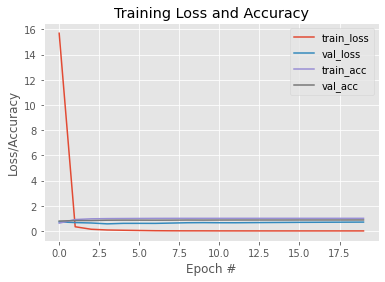

In [169]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Analysis on Cpatcha images
Til now we have evaluated and trained our model on charcter dataset, now we are going to test the accuracy of our model on captcha images.
A captcha image is said to be correctly predicted if all the characters in that image are correcty identified. 

In [170]:
from preprocess import Segmentation

In [171]:
def captcha(img, imgPath):
    parts=[]
    lbls=[]
    Segmentation(img,imgPath , parts, lbls)
    parts=np.array(parts)
    predictions = model.predict(parts, batch_size=32)
    for i in range(5):
        if np.where(le.classes_ ==lbls[i])[0] != predictions.argmax(axis=1)[i]:
            return 0
    return 1

In [172]:
t=0
# t = captcha(z[2], str(images[2]))
for i in range(len(z)):
    t+=captcha(z[i],str(images[i]))
print(t)

1/1 [==============================] - 0s 22ms/step
882


In [173]:
t/len(z)

0.8480769230769231